In [1]:
import pandas as pd
from swsm import SWSM # this library

# Determining key wake steering parameters from cross-sections

This section describes how to use the Multiple 1D Gaussian code on vertical cross-sections to obtain the key wake steering parameters used in SWSM.
In this example, we have simulated the interaction between a Neutral Boundary Layer and a NREL 5MW turbine (hub height = 90 m, rotor diameter = 126 m).
Three yaw angles are considered: 0$^{\circ}$ ($yaw\_00.nc$), +30$^{\circ}$ ($yaw\_30.nc$) and -30$^{\circ}$ ($yaw\_-30.nc$). 


In [2]:
sims = ['yaw_00','yaw_30','yaw_-30'] ## Names of simulations
testcase = SWSM()
testcase.determine_key_parameters(sims)

Determining key wake steering parameters


/home/luuk/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Done


The object SWSM is the main API for this model as is here renamed as wake_model. 
The first step is to determine the key wake steering parameters from an existing dataset, which is done in $.determine\_key\_parameters(sims)$. This function read the netcdf files in $load\_crosssections(path\_to\_file)$. In this example, the netCDF files contain the following information:
* x: distance downstream of turbine normalized by rotor diameter; x = 1 .. 10 D
* y: lateral location, centered around turbine location and normalized by rotor diameter; -2 D < y < 2 D
* z: z: vertical location, centered around hub height and normalized by rotor diameter; -0.7 D < z < 2 D
* $u_{normdef}$: the wake deficit normalized by the wind speed at hub height: $u_{normdef} = \frac{u_{wake} - u_{\infty}}{u_{\infty,hh}}$.
This variable contains data on each grid point (∆ = 5 m), structured as (z, y, x).

If a different data structure is used, it is advised to make changes in this function.

Next, $.determine\_key\_parameters(sims)$ calls the  $multi1Dgaus(z, y, u)$  function. This function computes the key wake steering parameters for each cross-section.

The $determine\_key\_parameters(sims)$ function is a wrapper that loops over all simulations (sims) and downstream distances and collects all key wake steering paramters in a dataframe saved as $.key\_parameters$.

This dataframe is structured as follows:
* The rows contain the simulations
* The columns contain all key wake steering parameters for all downstream locations

For example, this test case results a dataframe of size 3x90:


In [3]:
# round(testcase.key_parameters,3)
testcase.key_parameters

,A_z1,mu_y1,mu_z1,sigma_y1,sigma_z1,c1,t1,s_a1,s_b1,A_z2,...,s_b9,A_z10,mu_y10,mu_z10,sigma_y10,sigma_z10,c10,t10,s_a10,s_b10
yaw_00,-0.606948,-0.025295,0.058914,0.444261,0.611884,0.090099,-0.020752,-2.180993,0.012736,-0.638517,...,0.083182,-0.192698,-0.067398,0.052294,0.563203,0.635817,0.092917,0.003870,0.049468,0.043853
yaw_30,-0.481027,0.047651,0.032145,0.355417,0.625283,0.035730,0.002431,-2.155771,0.050517,-0.499684,...,-0.291038,-0.161804,0.398014,0.109881,0.426172,0.770508,-0.868518,0.474557,0.171546,-0.282656
yaw_-30,-0.481809,-0.094644,0.066922,0.352879,0.564390,0.143943,-0.022738,-2.145079,-0.068347,-0.497378,...,-0.611295,-0.142702,-0.707627,0.208671,0.501055,0.563897,1.218063,-0.450020,0.916674,-0.605879


# Specify input parameters
In a separate dataframe, we have to specify the input parameters. For the test case, this information
is provided in the file input.csv. It simply contains the $yaw$, $shear$ and $C_T$ values for these simulations. As discussed in the paper,
other input parameters can be used as long as one cluster is represented.

In [4]:
df_input = pd.read_csv('data/input.csv',index_col=0)
df_input.round(3)

,yaw,shear,Ct
yaw_00,0,0.165,0.74
yaw_30,30,0.165,0.61
yaw_-30,-30,0.165,0.61


# Training

Training of the SWMS is done by function $.train_coeffs(df_input,transformations,Ds)$. 
The input for this function is the following:

* $df\_input$: input parameters of $input.csv$

* transformations: the transformations to be applied to the input parameters. Allowed are:
    * '' = no transformation
    * 'log' = logarithmic
    * 'exp' = exponential
    * 'rec' = reciprocal (1/x)
    * 'sqrt' = square root

* Ds: downstream distanced to be used in determination of coefficients. Since this method does not include a near wake description (such as a double Gaussian), it is advised to only consider distances larger than 4 x/D.

The key wake steering parameters in $.key\_parameters$ are used to determine the regression coefficients based on the provided input data. These coefficients are saved in a lookup table called $.dict\_LUT$.

In [5]:
Ds = range(4,11) ## Distances downstream
transformations = ['','',''] ## specify transformations ['','log','exp','rec','sqrt']
testcase.train_coeffs(df_input,transformations,Ds) ## execute
testcase.dict_LUT.keys()

Determining coefficients
Done


dict_keys(['predictors', 'transformations', 'x/D', 'A_z', 'A_z_i', 'mu_y', 'mu_y_i', 'mu_z', 'mu_z_i', 'sigma_y', 'sigma_y_i', 'sigma_z', 'sigma_z_i', 'c', 'c_i', 't', 't_i', 's_a', 's_a_i', 's_b', 's_b_i'])

# Testing
The coefficients determined above can consequently be used to predict the key wake steering parameters when the input parameters are known.  

The function $.run\_wake\_model(input\_values)$ collects the data in the right format and calls the functions $wake\_model()$. that computes the key wake steering parameters. and $wake\_composition()$. that composes the a gridded cross-section of the wake from these parameters. Returned are the normalized y and z positions, as well as $u_{normdef}$ (z, y, x).

The function $.plot(y,z,u)$ will plot the created cross section at one downstream distance.

In [6]:
input_values = [15,0.165,0.65] ## input values for new case

In [7]:
testcase.run_wake_model(input_values) ## execute

Predicting wake for following settings: 
 Input parameters: ['yaw', 'shear', 'Ct'] 
 Input values [15, 0.165, 0.65] 
 Transformations:  ['', '', ''] 
 Distances downstream: [ 4  5  6  7  8  9 10]

Sucess: The wake parameters(y,z,u_normdef) are saved in .wake_yzu


/home/luuk/Desktop/python/SWSM_wrapper/Publishable/v1.0/swsm/wake_model.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  return du*np.exp(-((y-mu)**2)/(2*sigma**2))


In [8]:
testcase.wake_yzu ## y, z, and u_normdef data

{'y': [-2.0,
  -1.9603174603174602,
  -1.9206349206349207,
  -1.880952380952381,
  -1.8412698412698412,
  -1.8015873015873016,
  -1.7619047619047619,
  -1.7222222222222223,
  -1.6825396825396826,
  -1.6428571428571428,
  -1.6031746031746033,
  -1.5634920634920635,
  -1.5238095238095237,
  -1.4841269841269842,
  -1.4444444444444444,
  -1.4047619047619047,
  -1.3650793650793651,
  -1.3253968253968254,
  -1.2857142857142858,
  -1.246031746031746,
  -1.2063492063492063,
  -1.1666666666666667,
  -1.126984126984127,
  -1.0873015873015872,
  -1.0476190476190477,
  -1.007936507936508,
  -0.9682539682539683,
  -0.9285714285714286,
  -0.8888888888888888,
  -0.8492063492063492,
  -0.8095238095238095,
  -0.7698412698412699,
  -0.7301587301587301,
  -0.6904761904761905,
  -0.6507936507936508,
  -0.6111111111111112,
  -0.5714285714285714,
  -0.5317460317460317,
  -0.49206349206349204,
  -0.4523809523809524,
  -0.4126984126984127,
  -0.373015873015873,
  -0.3333333333333333,
  -0.29365079365079366,
 

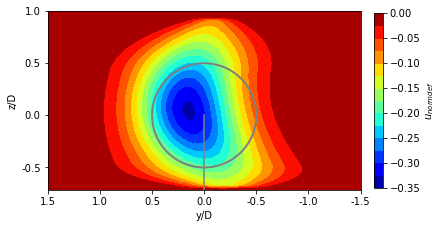

In [9]:
testcase.plot(D=1) ## 2nd calculated downstream distance, so 5 D

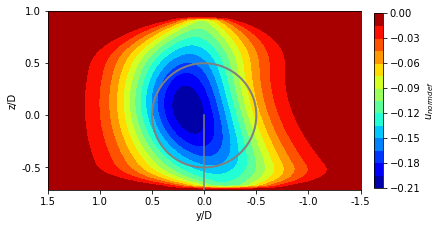

In [10]:
testcase.plot(D=4) ## 5th calculated downstream distance, so 8 D

# Finding optimum solution
This test case simply computes the coefficients based on one set of input parameters and transformations, but does not test for an optimal solution.
If desired, one should execute the following steps:
* Generate coefficient ($.dict\_LUT$) with set of input parameters and transformations (Training)
* Use these coefficients in the wake model to compute key wake steering parameters and compose the wake (Testing)
* Calculate power (or other measure of quality) and compare to original LES
* Repeat with other input parameters and transformations until optimum is found